In [19]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from scipy.stats import f_oneway, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the dataset
file_path = "/home/aricept094/mydata/my_cluster.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Select features for clustering
features = ['self_esteem_level', 'ADHD_type']
X = data[features]

# Encode categorical features (ADHD_type)
label_encoder = LabelEncoder()
X['ADHD_type'] = label_encoder.fit_transform(X['ADHD_type'])

# Apply BIRCH clustering
birch = Birch(threshold=0.9657, branching_factor=159, n_clusters=5)
birch.fit(X)
labels = birch.labels_

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Calinski-Harabasz Index
calinski_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {calinski_score}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

# Add cluster labels to the dataframe
data['cluster_num'] = labels

# --- Generate Report as a Table ---
# All column names
all_columns = [
    'age', 'gender', 'school_stage', 'fathers_education', 'mothers_education',
    'adhd_diagnosis_time', 'self_esteem_level', 'Permissive_Style',
    'Authoritarian_Style', 'Authoritative_Style', 'ADHD_type'
]

# ADHD type mapping
adhd_type_mapping = {
    0: "ADHD_Sub_Clinical",
    1: "ADHD_Inattentive",
    2: "ADHD_Hyperactive",
    3: "ADHD_Combined"
}

# Create an empty list to store the report data
report_data = []

# Iterate through each cluster
for cluster in sorted(data['cluster_num'].unique()):
    cluster_data = data[data['cluster_num'] == cluster]
    cluster_summary = {'Cluster': cluster}

    for column in all_columns:
        if pd.api.types.is_numeric_dtype(data[column]):
            if column == 'ADHD_type':
                # Handle ADHD_type as categorical
                adhd_counts = cluster_data['ADHD_type'].map(adhd_type_mapping).value_counts()
                for adhd_type, count in adhd_counts.items():
                    cluster_summary[adhd_type] = count  # Add counts for each ADHD type
            else:
                # Numerical features: Calculate mean only
                cluster_summary[column] = cluster_data[column].mean()
        else:
            # Categorical features: Get the most frequent value
            cluster_summary[column] = cluster_data[column].mode()[0]

    report_data.append(cluster_summary)

# Create a DataFrame from the report data
report_df = pd.DataFrame(report_data)

# Reorder columns to place categorical variables at the end
categorical_cols = ['gender', 'school_stage', 'fathers_education', 'mothers_education']
numerical_cols = [col for col in all_columns if col not in categorical_cols and col != 'ADHD_type']
adhd_cols = ["ADHD_Sub_Clinical", "ADHD_Inattentive", "ADHD_Hyperactive", "ADHD_Combined"]  # ADHD type columns
ordered_cols = ['Cluster'] + numerical_cols + categorical_cols + adhd_cols
report_df = report_df[ordered_cols]

# Fill NaN values with 0 for ADHD type counts
report_df[adhd_cols] = report_df[adhd_cols].fillna(0).astype(int)

# Display the report table
print(report_df)

# --- Statistical Significance Testing ---

# 1. ANOVA for numerical features
print("\n--- ANOVA for Numerical Features ---")
for col in numerical_cols:
    groups = [data[col][data['cluster_num'] == i] for i in range(5)]
    try:
        f_stat, p_value = f_oneway(*groups)
        
        # Post-hoc test (Tukey's HSD)
        model = ols(f'{col} ~ C(cluster_num)', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        tukey_result = sm.stats.multicomp.pairwise_tukeyhsd(data[col], data['cluster_num'])
        
        print(f"\n{col}:")
        print(f"  F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
        print(anova_table)
        print(tukey_result)

        if p_value < 0.05:
            print(f"  {col} is significantly different across clusters.")
        else:
            print(f"  {col} is not significantly different across clusters.")
    except ValueError:
        print(f"  Could not perform ANOVA for {col} due to insufficient data in one or more groups.")

# 2. Chi-squared test for categorical features
print("\n--- Chi-squared Test for Categorical Features ---")
for col in categorical_cols:
    contingency_table = pd.crosstab(data['cluster_num'], data[col])
    try:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"\n{col}:")
        print(f"  Chi2-statistic: {chi2_stat:.4f}, P-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"  {col} is significantly different across clusters.")
        else:
            print(f"  {col} is not significantly different across clusters.")
    except ValueError:
        print(f"  Could not perform Chi-squared test for {col} due to insufficient data in one or more groups.")

# 3. Chi-squared test for ADHD types
print("\n--- Chi-squared Test for ADHD Types ---")
contingency_table_adhd = pd.DataFrame({
    'ADHD_Sub_Clinical': [report_df['ADHD_Sub_Clinical'][i] for i in range(5)],
    'ADHD_Inattentive': [report_df['ADHD_Inattentive'][i] for i in range(5)],
    'ADHD_Hyperactive': [report_df['ADHD_Hyperactive'][i] for i in range(5)],
    'ADHD_Combined': [report_df['ADHD_Combined'][i] for i in range(5)]
}, index=range(5))

try:
    chi2_stat_adhd, p_value_adhd, dof_adhd, expected_adhd = chi2_contingency(contingency_table_adhd)
    print(f"  Chi2-statistic: {chi2_stat_adhd:.4f}, P-value: {p_value_adhd:.4f}")
    if p_value_adhd < 0.05:
        print("  ADHD types are significantly different across clusters.")
    else:
        print("  ADHD types are not significantly different across clusters.")
except ValueError:
    print("  Could not perform Chi-squared test for ADHD types due to insufficient data in one or more groups.")

# Save the updated dataframe (optional)
output_file_path = "/home/aricept094/mydata/my_cluster_with_clusters.xlsx" # Replace with your desired output path
data.to_excel(output_file_path, index=False)
print(f"\nData with cluster numbers saved to: {output_file_path}")

/tmp/ipykernel_1406/2966709961.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ADHD_type'] = label_encoder.fit_transform(X['ADHD_type'])


Silhouette Score: 0.6489568248884366
Calinski-Harabasz Index: 151.20049194645625
Davies-Bouldin Index: 0.538888490243918
   Cluster        age  adhd_diagnosis_time  self_esteem_level  \
0        0  13.000000             2.769231           0.000000   
1        1   9.555556             2.000000           2.666667   
2        2  10.583333             2.750000           3.416667   
3        3  10.541667             2.000000           0.333333   
4        4  10.222222             2.222222           1.444444   

   Permissive_Style  Authoritarian_Style  Authoritative_Style    gender  \
0         19.071429            11.500000            32.785714  0.714286   
1         17.444444            13.000000            30.888889  0.833333   
2         17.083333            12.250000            29.833333  0.833333   
3         18.166667            11.875000            30.125000  0.833333   
4         18.444444            10.333333            32.222222  0.777778   

   school_stage  fathers_education  m

/tmp/ipykernel_1406/2876639673.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ADHD_type'] = label_encoder.fit_transform(X['ADHD_type'])


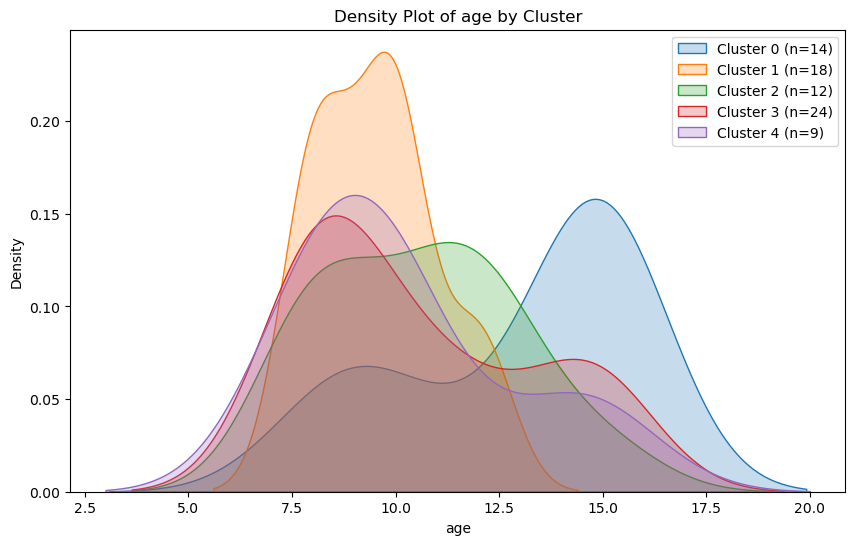

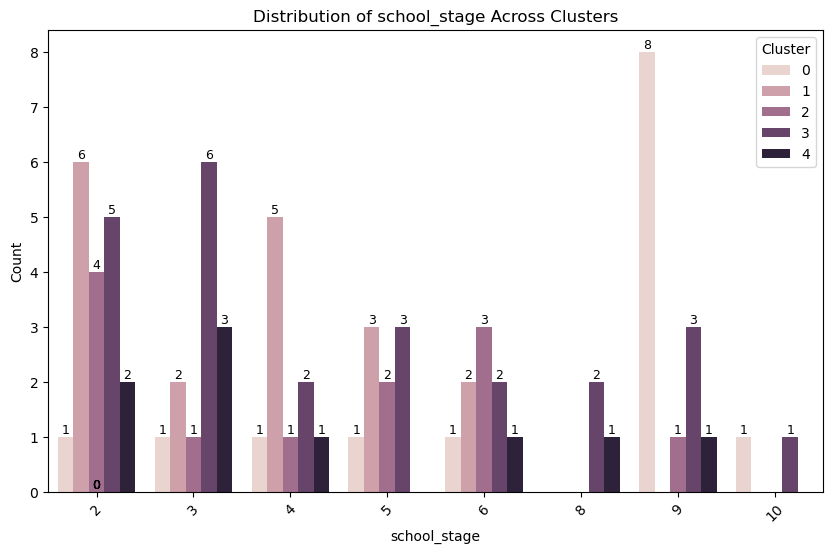

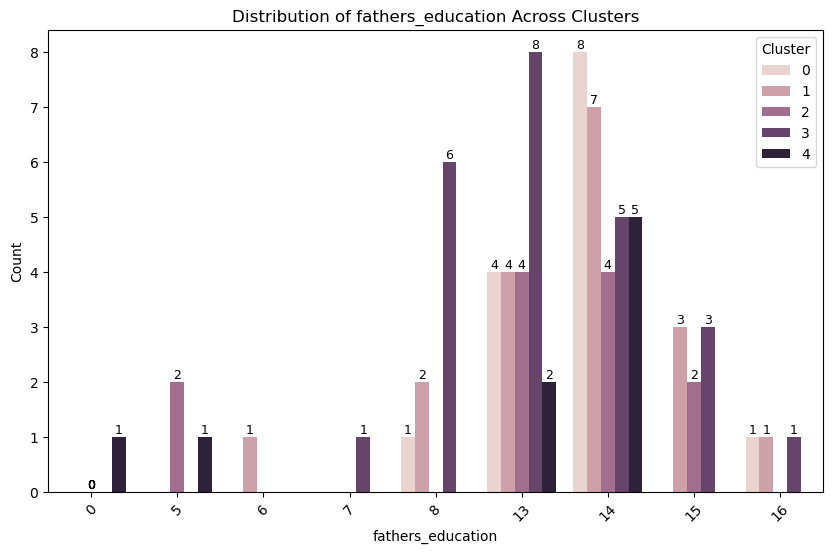

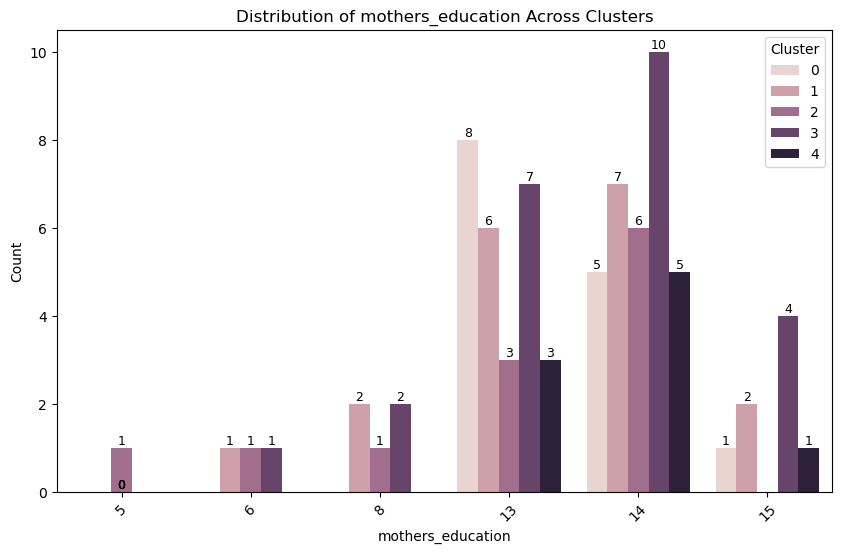

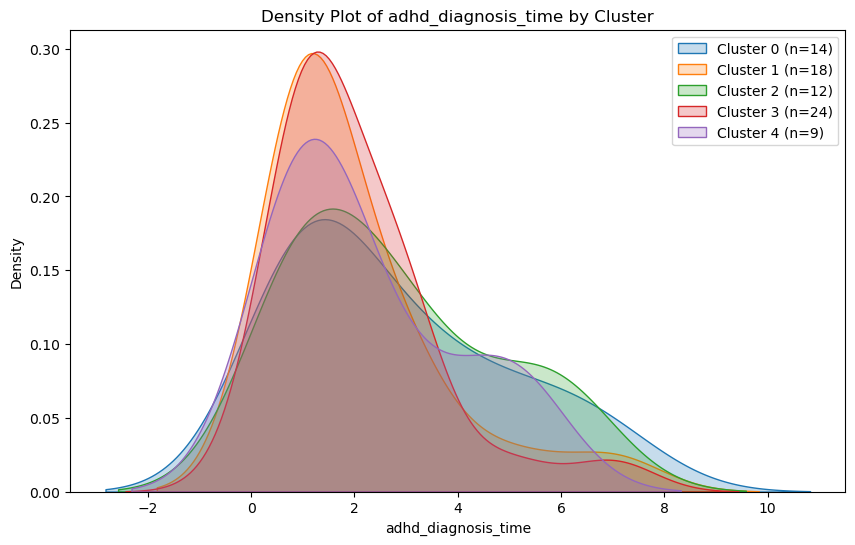

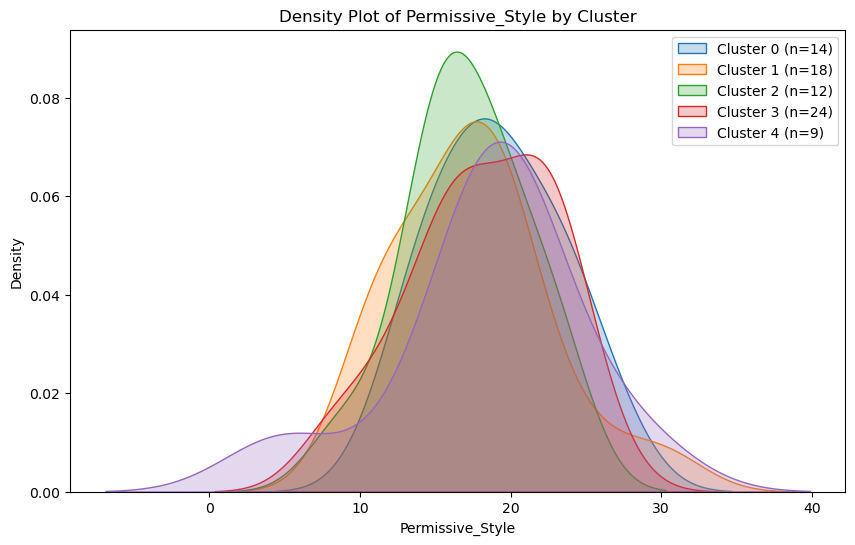

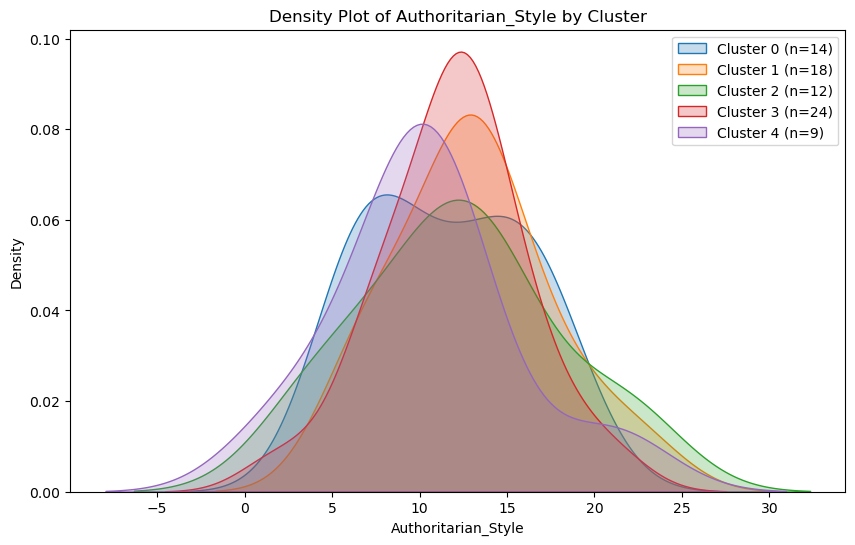

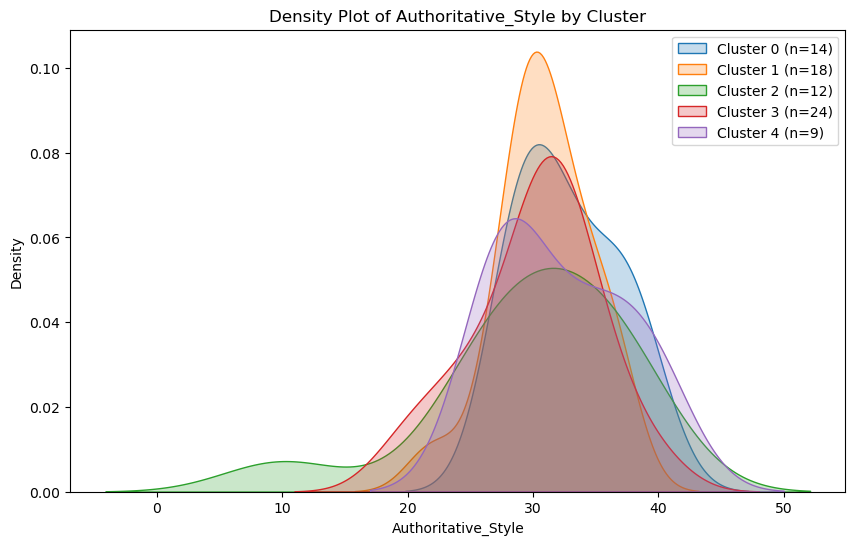

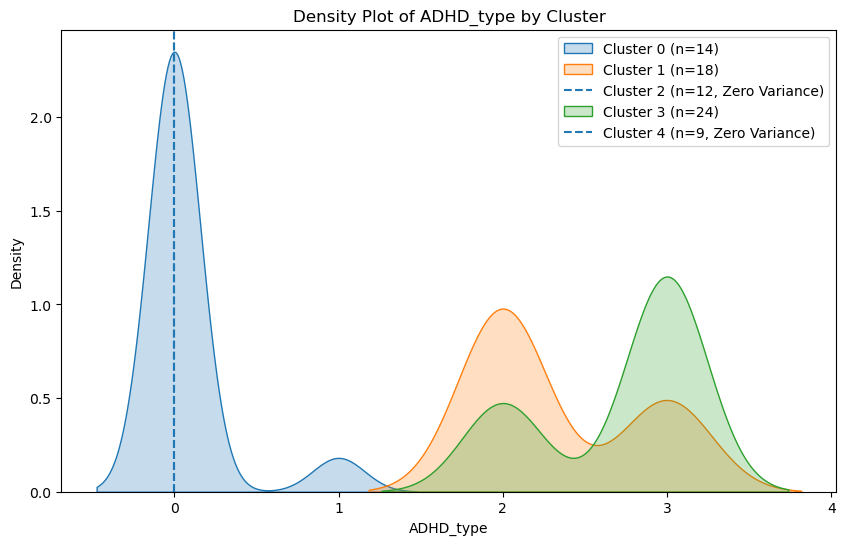

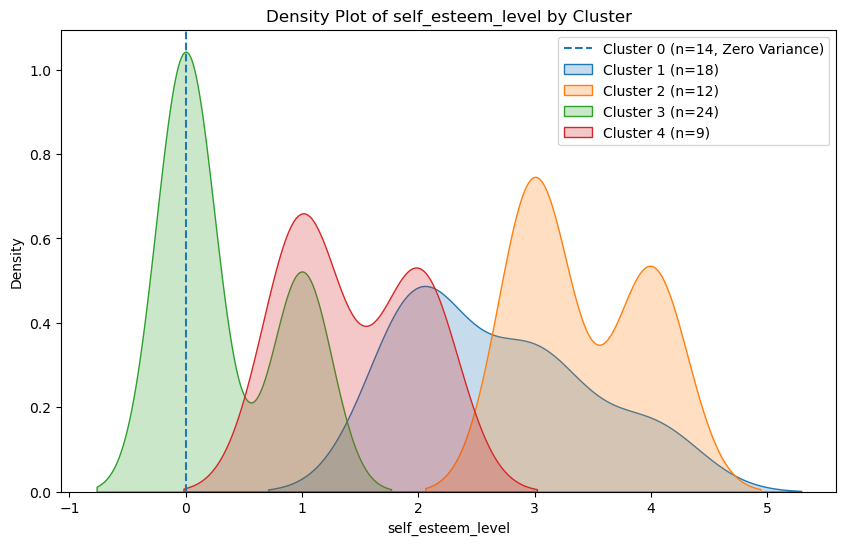

In [15]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
file_path = "/home/aricept094/mydata/my_cluster.xlsx"
data = pd.read_excel(file_path)

# Select features for clustering
features = ['self_esteem_level', 'ADHD_type']
X = data[features]

# Encode categorical features (ADHD_type)
label_encoder = LabelEncoder()
X['ADHD_type'] = label_encoder.fit_transform(X['ADHD_type'])

# Scale the features
scaler = StandardScaler()
X_scaled = X

# Apply BIRCH clustering
birch = Birch(threshold=0.9657, branching_factor=159, n_clusters=5)
birch.fit(X_scaled)
labels = birch.labels_

# Add cluster labels to the dataframe
data['cluster_num'] = labels

# --- Density Plots ---

# Features for density plots (treating ADHD_type as continuous now)
features_to_plot = [
    'age', 'school_stage', 'fathers_education', 'mothers_education',
    'adhd_diagnosis_time', 'Permissive_Style', 'Authoritarian_Style',
    'Authoritative_Style', 'ADHD_type', 'self_esteem_level'
]

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))

    if feature == 'school_stage' or feature == 'fathers_education' or feature == 'mothers_education':
        # Categorical Feature: Count Plot
        ax = sns.countplot(data=data, x=feature, hue='cluster_num')  # Get the Axes object
        plt.title(f'Distribution of {feature} Across Clusters')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.xticks(rotation=45)

        # Add number of cases to the count plot
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                        textcoords='offset points')

        plt.legend(title='Cluster')

    elif pd.api.types.is_numeric_dtype(data[feature]):
        # Continuous Feature: Density Plot
        for cluster in sorted(data['cluster_num'].unique()):
            cluster_data = data[data['cluster_num'] == cluster][feature]
            num_cases = len(cluster_data)

            if cluster_data.var() == 0:
                # Handle zero variance
                plt.axvline(cluster_data.iloc[0], label=f'Cluster {cluster} (n={num_cases}, Zero Variance)', linestyle='--')

            else:
                # Regular density plot
                sns.kdeplot(cluster_data, label=f'Cluster {cluster} (n={num_cases})', fill=True)

        plt.title(f'Density Plot of {feature} by Cluster')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()

    plt.show()